This notebook is guided by this [Kaggle kernel](https://www.kaggle.com/davids1992/speech-representation-and-data-exploration) and look into wave data features.
## Agenda
[Wave data explorer](#Wave-data-explorer)  
[Data statistics](#Data-statistics)  
[Insights](#Insights)

In [3]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

<h2>Wave data explorer</h2>
[Agenda](#Agenda)  
In speech recognition, I see two main tendencies - to input spectrogram (frequencies), and more sophisticated features MFCC - Mel-Frequency Cepstral Coefficient

In [37]:
train_audio_path = '/home/maikfangogoair/tmp/label_data/'
filename = '/yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [38]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

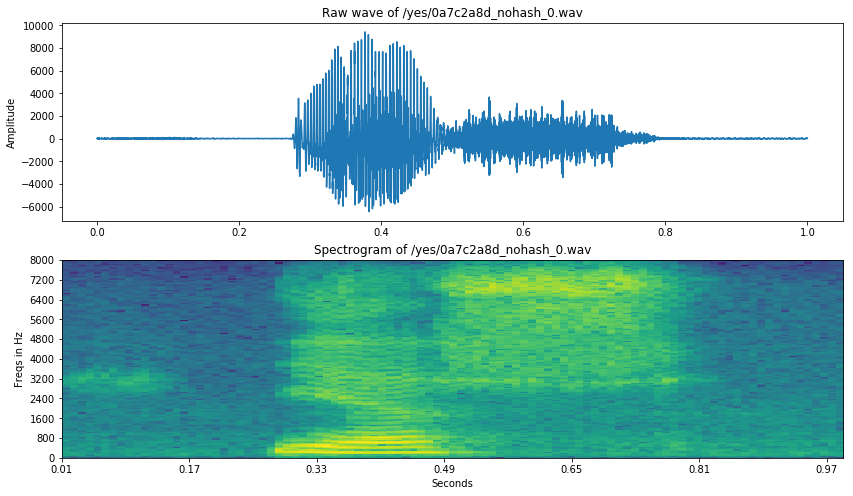

In [39]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

def gen_spectrogram_plot(samples,sample_rate,spectrogram,freqs,times,filename):
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave of ' + filename)
    ax1.set_ylabel('Amplitude')
    ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

    ax2 = fig.add_subplot(212)
    ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax2.set_yticks(freqs[::16])
    ax2.set_xticks(times[::16])
    ax2.set_title('Spectrogram of ' + filename)
    ax2.set_ylabel('Freqs in Hz')
    ax2.set_xlabel('Seconds')
    
gen_spectrogram_plot(samples,sample_rate,spectrogram,freqs,times,filename)

In [69]:
print(freqs.shape)
print(times.shape)
print(spectrogram.shape)

(161,)
(99,)
(99, 161)


In [20]:
#normalization
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

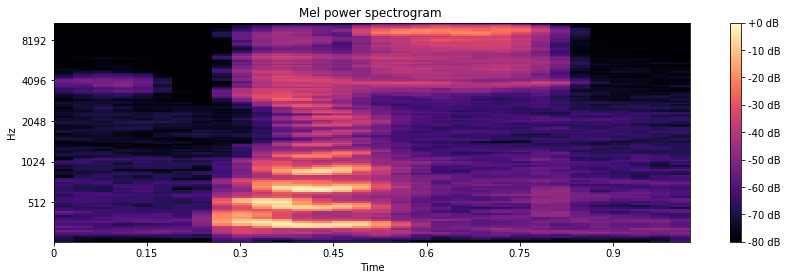

In [27]:
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

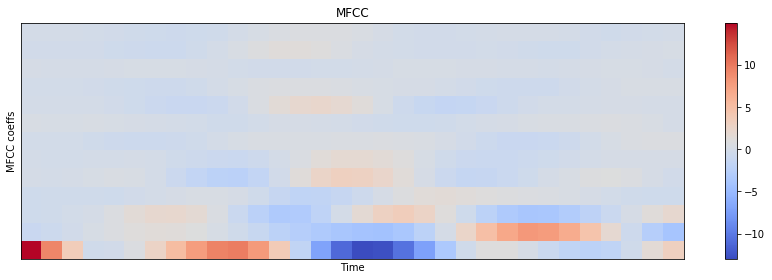

In [30]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [37]:
delta2_mfcc.shape

(13, 32)

In [39]:
ipd.Audio(samples, rate=sample_rate)

In [40]:
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

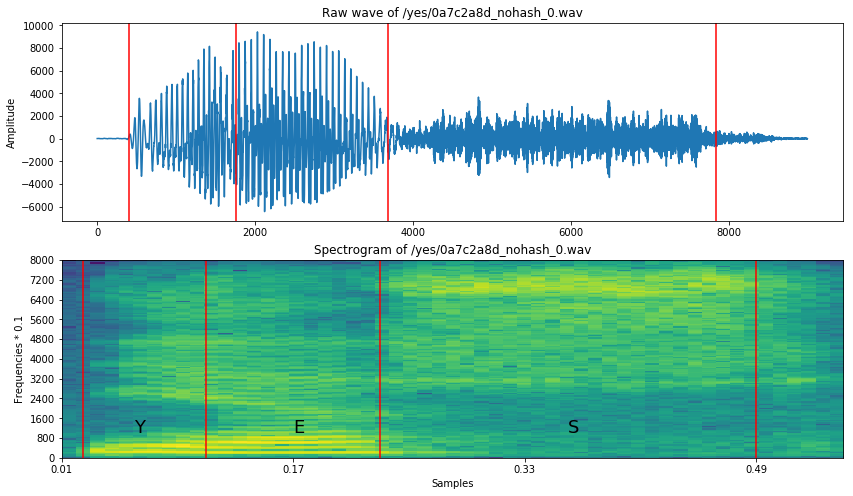

In [41]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

In [43]:
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [44]:
ipd.Audio(samples, rate=sample_rate)

In [45]:
ipd.Audio(resampled, rate=new_sample_rate)

In [42]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

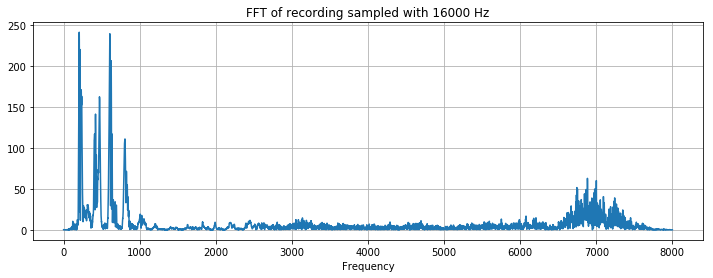

In [46]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

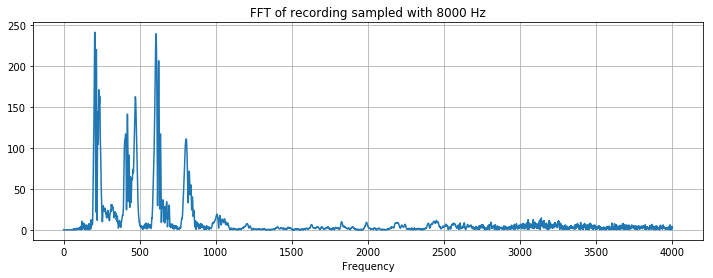

In [47]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

<h2>Data statistics</h2>
[Agenda](#Agenda)  

In [48]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 31


In [61]:
# Calculate
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

# Plot
data = [go.Histogram(x=dirs, y=number_of_recordings)]
for x,y in zip(data[0]['x'],data[0]['y']):
    print(x,y)

_background_noise_ 6
bed 1713
bird 1731
cat 1733
dog 1746
down 2359
eight 2352
five 2357
four 2372
go 2372
happy 1742
house 1750
left 2353
marvin 1746
nine 2364
no 2375
off 2357
on 2367
one 2370
right 2367
seven 2377
sheila 1734
six 2369
stop 2380
three 2356
tree 1733
two 2373
up 2375
wow 1745
yes 2377
zero 2376


In [59]:
num_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))

Number of recordings shorter than 1 second: 6469


/home/maikfangogoair/assignment1/.env/lib/python3.5/site-packages/scipy/io/wavfile.py:179: WavFileWarning:

Chunk (non-data) not understood, skipping it.



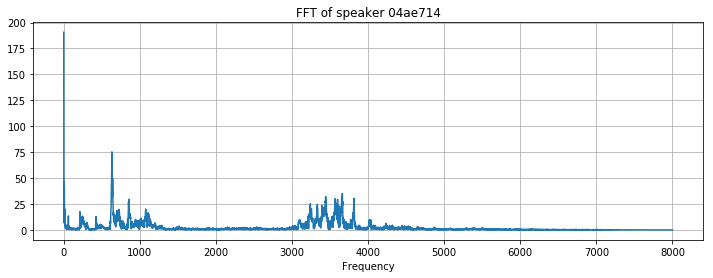

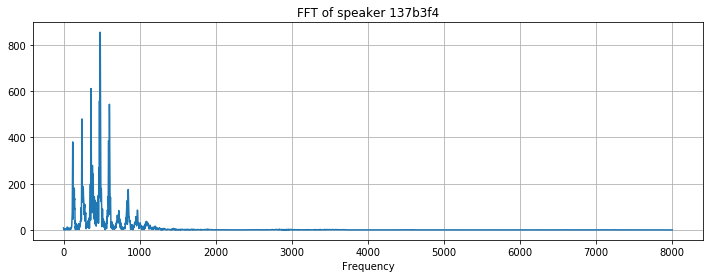

In [62]:
filenames = ['on/004ae714_nohash_0.wav', 'on/0137b3f4_nohash_0.wav']
for filename in filenames:
    sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of speaker ' + filename[4:11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

In [63]:
print('Speaker ' + filenames[0][4:11])
ipd.Audio(join(train_audio_path, filenames[0]))

Speaker 04ae714


In [64]:
print('Speaker ' + filenames[1][4:11])
ipd.Audio(join(train_audio_path, filenames[1]))

Speaker 137b3f4


In [67]:
ipd.Audio(join(train_audio_path, 'yes/01bb6a2a_nohash_1.wav'))

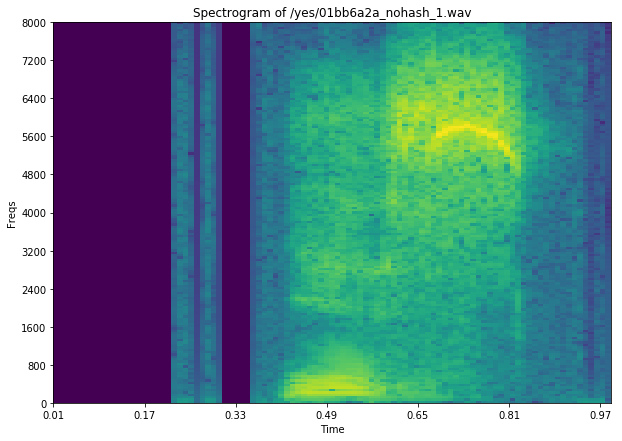

In [65]:
filename = '/yes/01bb6a2a_nohash_1.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10, 7))
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


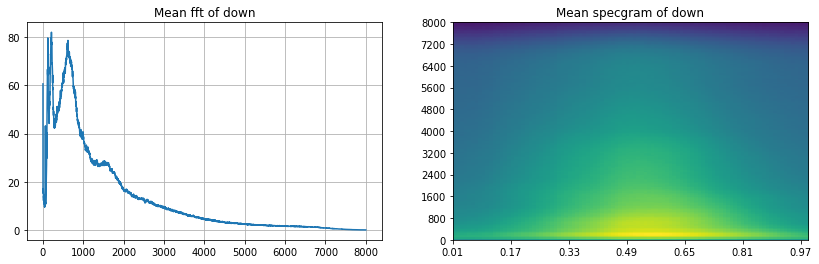

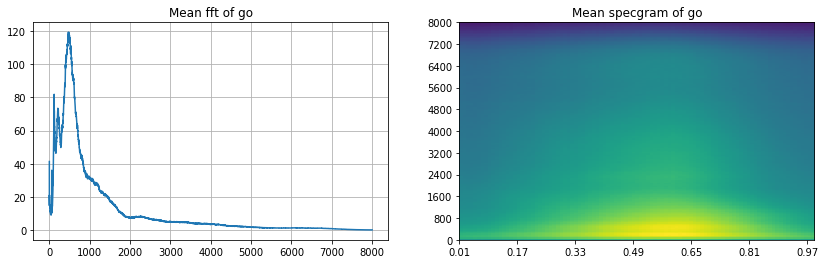

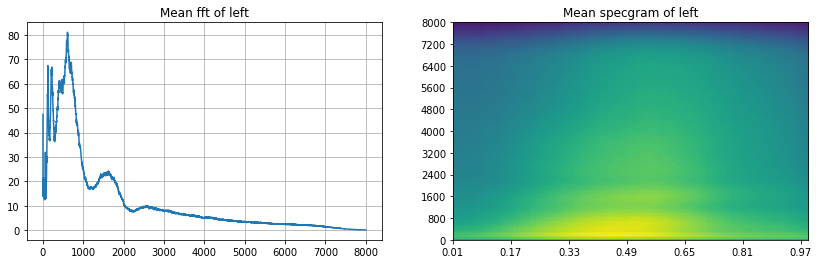

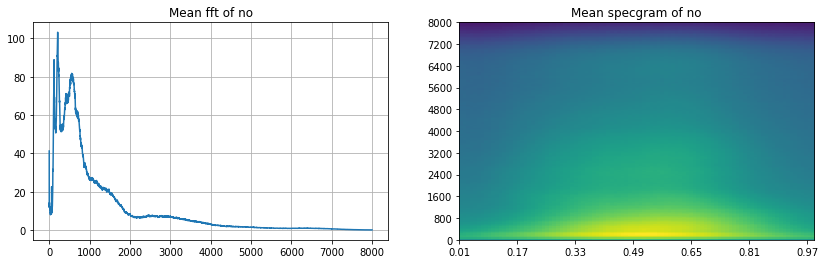

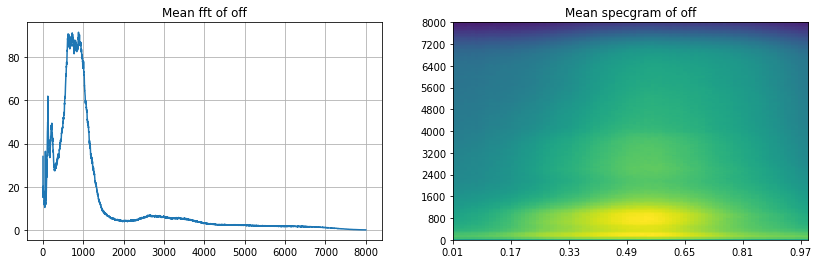

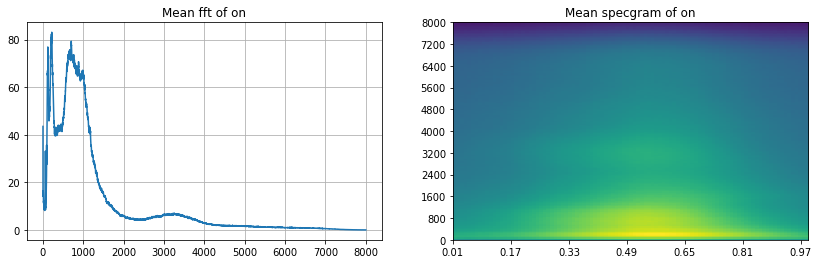

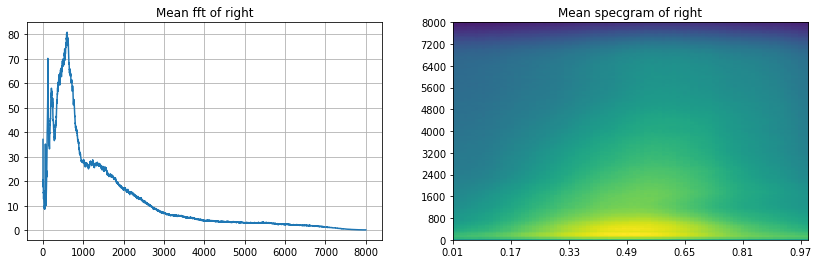

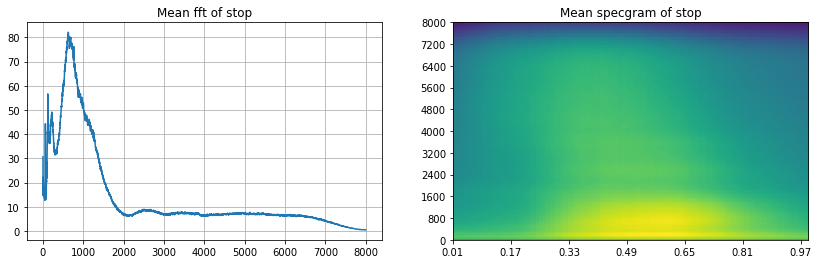

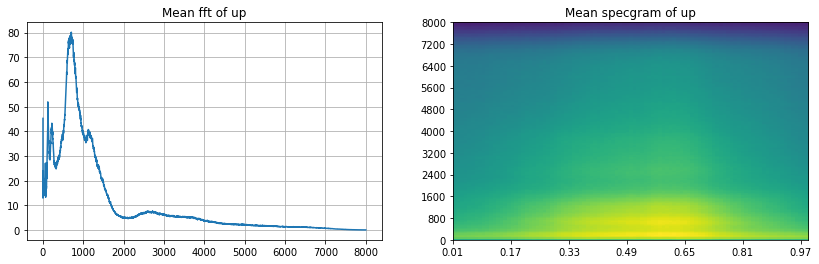

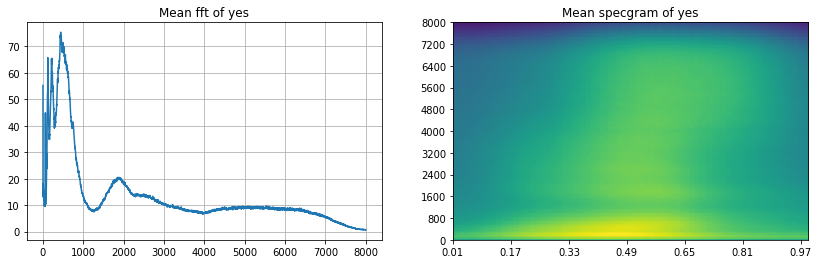

In [68]:
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

In [69]:
def violinplot_frequency(dirs, freq_ind):
    """ Plot violinplots for given words (waves in dirs) and frequency freq_ind
    from all frequencies freqs."""

    spec_all = []  # Contain spectrograms
    ind = 0
    for direct in dirs:
        spec_all.append([])

        waves = [f for f in os.listdir(join(train_audio_path, direct)) if
                 f.endswith('.wav')]
        for wav in waves[:100]:
            sample_rate, samples = wavfile.read(
                train_audio_path + direct + '/' + wav)
            freqs, times, spec = log_specgram(samples, sample_rate)
            spec_all[ind].extend(spec[:, freq_ind])
        ind += 1

    # Different lengths = different num of frames. Make number equal
    minimum = min([len(spec) for spec in spec_all])
    spec_all = np.array([spec[:minimum] for spec in spec_all])

    plt.figure(figsize=(13,7))
    plt.title('Frequency ' + str(freqs[freq_ind]) + ' Hz')
    plt.ylabel('Amount of frequency in a word')
    plt.xlabel('Words')
    sns.violinplot(data=pd.DataFrame(spec_all.T, columns=dirs))
    plt.show()

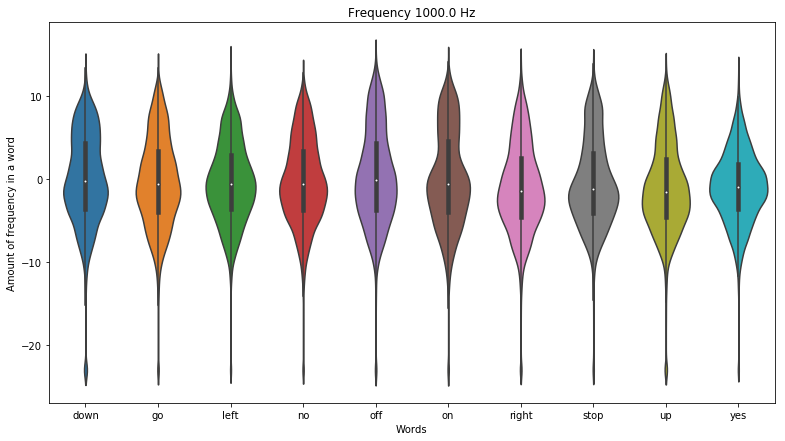

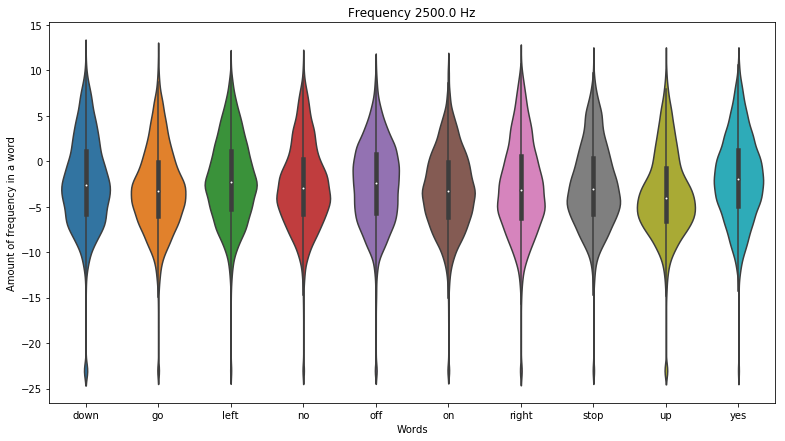

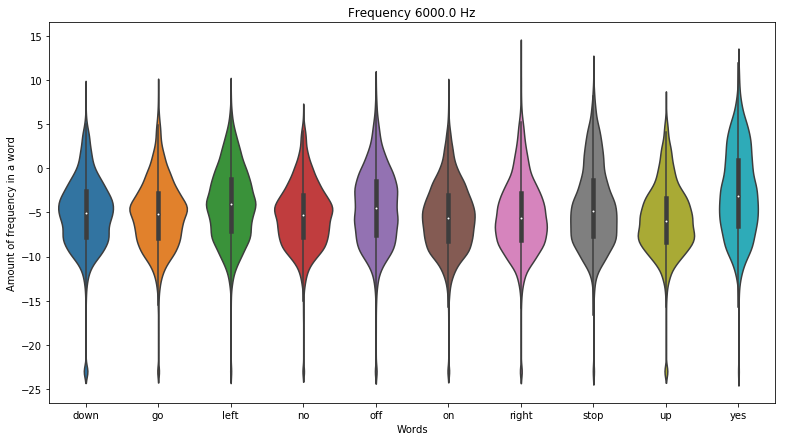

In [72]:
violinplot_frequency(dirs, 20)
violinplot_frequency(dirs, 50)
violinplot_frequency(dirs, 120)

<h2>Insights</h2>
[Agenda](#Agenda) 
* it's possible to resample dataset to 8k rate to reduce dimensionality
* there is almost no information above 4000 Hz in original signal as FFT(Fast Fourier Transform).
* randomly add backgroud data(exluce when testing)
* VAD (Voice Activity Detection) can reduce the data size, and catch the useful feature,for example webrtcvad package.
* make sure one speaker's wave in one group(training/validation/testing)
* padding with 0 to make signals be equal length
* Features normalization with mean and std over all dataset
* Stacking of a given number of frames to get temporal information
* any feature on speaker gender,age,country?


In [6]:
train_audio_path = '/home/maikfangogoair/tmp/label_data/'
wave_files = {x:os.listdir(train_audio_path+x) for x in os.listdir(train_audio_path) if os.path.isdir(train_audio_path+x)}

In [19]:
def get_sample_spectrogram(label, filename):
    """
    * get sample and spectrogram
    * adding to 16000 samples if less
    * padding to 1 second if less
    """
    sample_rate, samples = wavfile.read(str(train_audio_path) + label + "/" + filename)
    freqs, times, spectrogram = log_specgram(samples, sample_rate)
    if samples.shape[0] < 16000 :
        samples=np.lib.pad(samples, (0,16000-samples.shape[0]), 'constant', constant_values=(0, 0))
        to_stack = np.mean(spectrogram[-10:], axis=0).reshape(-1,1).dot(np.ones((1,99-spectrogram.shape[0]))).T
        spectrogram = np.vstack((spectrogram,to_stack))
    return samples,freqs, times, spectrogram

In [47]:
#copy from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/speech_commands/input_data.py#L61
import re
import hashlib
from tensorflow.python.util import compat
def which_set(filename, validation_percentage, testing_percentage):
  """Determines which data partition the file should belong to.
  We want to keep files in the same training, validation, or testing sets even
  if new ones are added over time. This makes it less likely that testing
  samples will accidentally be reused in training when long runs are restarted
  for example. To keep this stability, a hash of the filename is taken and used
  to determine which set it should belong to. This determination only depends on
  the name and the set proportions, so it won't change as other files are added.
  It's also useful to associate particular files as related (for example words
  spoken by the same person), so anything after '_nohash_' in a filename is
  ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
  'bobby_nohash_1.wav' are always in the same set, for example.
  Args:
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.
  Returns:
    String, one of 'training', 'validation', or 'testing'.
  """
  base_name = os.path.basename(filename)
  # We want to ignore anything after '_nohash_' in the file name when
  # deciding which set to put a wav in, so the data set creator has a way of
  # grouping wavs that are close variations of each other.
  hash_name = re.sub(r'_nohash_.*$', '', base_name)
  # This looks a bit magical, but we need to decide whether this file should
  # go into the training, testing, or validation sets, and we want to keep
  # existing files in the same set even if more files are subsequently
  # added.
  # To do that, we need a stable way of deciding based on just the file name
  # itself, so we do a hash of that and then use that to generate a
  # probability value that we use to assign it.
  hash_name_hashed = hashlib.sha1(compat.as_bytes(hash_name)).hexdigest()
  MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M
  percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))
  if percentage_hash < validation_percentage:
    result = 'validation'
  elif percentage_hash < (testing_percentage + validation_percentage):
    result = 'testing'
  else:
    result = 'training'
  return result


In [178]:
"""
create all data into a list

"""
import random
random.seed(59185)
validation_percentage = 10
testing_percentage = 10
unknown_percentage = 10
word_list = ['silence','unknown', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
all_data = [];
for label in os.listdir(train_audio_path):
    if os.path.isdir(train_audio_path+label) and label != "_background_noise_":
        for filename in os.listdir(train_audio_path+label):
            if filename.endswith('.wav'):
                if label in word_list:
                    samples, freqs, times, spectrogram = get_sample_spectrogram(label, filename)
                    all_data.append({"label":label, "label_idx":word_list.index(label),"filename":filename, \
                                     "speaker":filename.split('_')[0],\
                                    "samples":samples , "spectrogram": spectrogram, \
                                     "group": which_set(filename, validation_percentage, testing_percentage),\
                                    "freqs":freqs, "times":times})
                elif random.randint(1,100) <= unknown_percentage:
                    samples, freqs, times, spectrogram = get_sample_spectrogram(label, filename)
                    all_data.append({"label":label, "label_idx": 1,"filename":filename, \
                                     "speaker":filename.split('_')[0],\
                                    "samples":samples , "spectrogram": spectrogram, \
                                     "group": which_set(filename, validation_percentage, testing_percentage),\
                                    "freqs":freqs, "times":times})

random.shuffle(all_data)

In [179]:
def get_label(label):
    word_list = ['silence','unknown', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
    if label in word_list:
        pass
    else :
        label = "unknown"
    return label

data_statistics = {"validation":{},"testing":{},"training":{}}
for x in all_data:
    data_statistics[x["group"]][get_label(x["label"])] = data_statistics[x["group"]].get(get_label(x["label"]),0) + 1
data_statistics

{'testing': {'down': 253,
  'go': 251,
  'left': 267,
  'no': 252,
  'off': 262,
  'on': 246,
  'right': 259,
  'stop': 249,
  'unknown': 412,
  'up': 272,
  'yes': 256},
 'training': {'down': 1842,
  'go': 1861,
  'left': 1839,
  'no': 1853,
  'off': 1839,
  'on': 1864,
  'right': 1852,
  'stop': 1885,
  'unknown': 3380,
  'up': 1843,
  'yes': 1860},
 'validation': {'down': 264,
  'go': 260,
  'left': 247,
  'no': 270,
  'off': 256,
  'on': 257,
  'right': 256,
  'stop': 246,
  'unknown': 415,
  'up': 260,
  'yes': 261}}

In [180]:
#check if any speaker in different group?
speaker_list = {}
for x in all_data:
    l = speaker_list.get(x["speaker"], {})
    if x["group"] in l.keys():
        speaker_list[x["speaker"]][x["group"]] += 1
    else:
        l[x["group"]] = 1
        speaker_list[x["speaker"]] = l
print("There are %d different speakers." % len(speaker_list))
print("There are %d speakers have more than one group." % len([{k,v} for k,v in speaker_list.items() if len(v.items()) > 1]))
#check sum
summary = 0
for _, v in speaker_list.items():
    summary = summary + v.get("training",0) + v.get("testing",0) +v.get("validation",0)
assert summary == len(all_data)
print("Total wave count is: %d." %  summary  )

There are 1850 different speakers.
There are 0 speakers have more than one group.
Total wave count is: 27889.


In [182]:
#save
data_dir = "/home/maikfangogoair/tmp/save/"
import pickle
with open(data_dir + "spectrogram_v1.pkl", 'wb') as fp:
    pickle.dump(all_data, fp)
# del all_data
# #open
# with open (data_dir + "spectrogram_v1.pkl", 'rb') as fp:
#     all_data = pickle.load(fp)

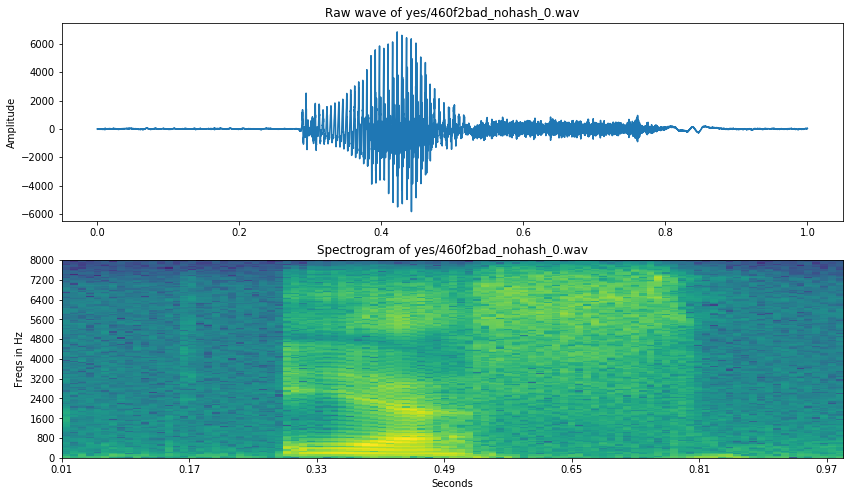

In [183]:
a = all_data[0]
gen_spectrogram_plot(a["samples"],16000,a["spectrogram"],a["freqs"],a["times"],a["label"]+"/"+a["filename"])

In [184]:
ipd.Audio(join(train_audio_path, a["label"]+"/"+a["filename"]))